# Analyzing Slack logs from NeIC channels

## TODO
- use examples from github.com/jalajthanaki/NLPython
- train sentiment analysis engine on some samples
- remove backslashes from words like it's

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [111]:
import json
import os
import sys
print(sys.version)
#reload(sys)  
#sys.setdefaultencoding('utf8')
from __future__ import division

2.7.14 | packaged by conda-forge | (default, Nov  4 2017, 10:22:41) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]


### Get the raw data

In [112]:
%%bash
mkdir slack_logs
cd slack_logs
mv ../NeIC_Slack_export_Dec10_2017.zip .
unzip NeIC_Slack_export_Dec10_2017.zip
cd ..

Archive:  NeIC_Slack_export_Dec10_2017.zip


mkdir: slack_logs: File exists
mv: ../NeIC_Slack_export_Dec10_2017.zip: No such file or directory
replace random/2017-09-22.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [c]
replace random/2017-09-22.json? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(assuming [N]one)


### Inspect directory structure

In [113]:
%ls slack_logs/

2nd-ndsw/                         loke/
NeIC_Slack_export_Dec10_2017.zip  metacenter/
_aa/                              music/
aai/                              ndgf/
ahm/                              ndgf-247/
ahm-planning/                     ndgf_groupchat_nordu_/
ahm-social/                       neic2017/
ahm16/                            nimbus/
ahm17/                            nlpl/
arc-debugging/                    perfsonardeploy/
arc-operations/                   pmf/
bdi/                              poco/
ce-debugging/                     prjmgt/
channels.json                     random/
coc/                              robotics/
coderefinery/                     sc17/
data/                             sgas/
dcache/                           teamwork/
dellingr/                         tryggve/
docker/                           tryggve-d2/
esm/                              tryggve-d3/
fgi/                              tryggve-pm/
fla/                              tryggve-r

In [114]:
dirs = %sx ls -d slack_logs/*/
for n,i in enumerate(dirs):
    print(n,i)

(0, 'slack_logs/2nd-ndsw/')
(1, 'slack_logs/_aa/')
(2, 'slack_logs/aai/')
(3, 'slack_logs/ahm-planning/')
(4, 'slack_logs/ahm-social/')
(5, 'slack_logs/ahm/')
(6, 'slack_logs/ahm16/')
(7, 'slack_logs/ahm17/')
(8, 'slack_logs/arc-debugging/')
(9, 'slack_logs/arc-operations/')
(10, 'slack_logs/bdi/')
(11, 'slack_logs/ce-debugging/')
(12, 'slack_logs/coc/')
(13, 'slack_logs/coderefinery/')
(14, 'slack_logs/data/')
(15, 'slack_logs/dcache/')
(16, 'slack_logs/dellingr/')
(17, 'slack_logs/docker/')
(18, 'slack_logs/esm/')
(19, 'slack_logs/fgi/')
(20, 'slack_logs/fla/')
(21, 'slack_logs/general/')
(22, 'slack_logs/glenna/')
(23, 'slack_logs/hpc-core_conference_c/')
(24, 'slack_logs/kudohugbox/')
(25, 'slack_logs/loke/')
(26, 'slack_logs/metacenter/')
(27, 'slack_logs/music/')
(28, 'slack_logs/ndgf-247/')
(29, 'slack_logs/ndgf/')
(30, 'slack_logs/ndgf_groupchat_nordu_/')
(31, 'slack_logs/neic2017/')
(32, 'slack_logs/nimbus/')
(33, 'slack_logs/nlpl/')
(34, 'slack_logs/perfsonardeploy/')
(35, 's

#### Let's first try out one channel

In [115]:
#dir = dirs[3] #ahm-planning
dir = dirs[13] #coderefinery

os.listdir(dir)

['2016-02-22.json',
 '2016-03-08.json',
 '2016-03-09.json',
 '2016-03-10.json',
 '2016-03-11.json',
 '2016-03-18.json',
 '2016-03-31.json',
 '2016-04-03.json',
 '2016-04-04.json',
 '2016-04-12.json',
 '2016-04-14.json',
 '2016-05-01.json',
 '2016-05-02.json',
 '2016-05-11.json',
 '2016-05-17.json',
 '2016-05-20.json',
 '2016-05-22.json',
 '2016-05-23.json',
 '2016-06-13.json',
 '2016-06-14.json',
 '2016-06-20.json',
 '2016-07-07.json',
 '2016-07-08.json',
 '2016-07-29.json',
 '2016-08-16.json',
 '2016-08-17.json',
 '2016-08-22.json',
 '2016-08-29.json',
 '2016-08-30.json',
 '2016-09-02.json',
 '2016-09-06.json',
 '2016-09-07.json',
 '2016-09-12.json',
 '2016-09-13.json',
 '2016-09-14.json',
 '2016-09-22.json',
 '2016-09-27.json',
 '2016-09-28.json',
 '2016-09-29.json',
 '2016-09-30.json',
 '2016-10-03.json',
 '2016-10-04.json',
 '2016-10-05.json',
 '2016-10-06.json',
 '2016-10-07.json',
 '2016-10-08.json',
 '2016-10-09.json',
 '2016-10-10.json',
 '2016-10-11.json',
 '2016-10-12.json',


Look at the structure of the json files

In [116]:
dates = os.listdir(dir)
d = dates[0] 
with open(dir+d,"r") as f:
    raw_json = json.loads(f.read())
dump = json.dumps(raw_json,indent=4)
print(dump)


[
    {
        "subtype": "channel_join", 
        "type": "message", 
        "user": "U0A9NV7PX", 
        "ts": "1456141994.000002", 
        "text": "<@U0A9NV7PX> has joined the channel"
    }, 
    {
        "text": "<@U0KV7FVNV> has joined the channel", 
        "ts": "1456141994.000003", 
        "subtype": "channel_join", 
        "inviter": "U0A9NV7PX", 
        "type": "message", 
        "user": "U0KV7FVNV"
    }, 
    {
        "text": "Is the name now official? If yes, then I will set up a rudimentary website. This would help me to contact people, then I have a link to refer them to.", 
        "type": "message", 
        "user": "U0KV7FVNV", 
        "ts": "1456142521.000004"
    }
]


Aha, `subtype` only present if it's not a regular message

In [117]:
for j in raw_json:
    if "subtype" in j.keys():
        print (j["type"], j["subtype"], j["text"])
    else:
        print(j["type"], j["text"])


(u'message', u'channel_join', u'<@U0A9NV7PX> has joined the channel')
(u'message', u'channel_join', u'<@U0KV7FVNV> has joined the channel')
(u'message', u'Is the name now official? If yes, then I will set up a rudimentary website. This would help me to contact people, then I have a link to refer them to.')


### Preprocessing

We now extract all regular messages

In [118]:
dates = os.listdir(dir)
messages = []
for d in dates: 
    with open(dir+d,"r") as f:
        raw_json = json.loads(f.read())

    for j in raw_json:
        if not "subtype" in j.keys(): # exclude non-message messages
            messages.append(j["text"])


1) In several places you mention and focus on "running"
the software, e.g. "impossible to run outside", "difference
between running and being robust", "tests to show to that
it actually runs". This is good and understandable in the Python/R
communities but in Fortran/C/C++-heavy physics/chemistry
communities building the software can be a barrier for users
and is of huge concern for portability (so is running but before the running
comes the building). If you want to mention
this and go this way, then you could recommend to use standard
build tools (Make, Autotools, CMake; the last would be my fav)
and not home-cooked configuration and build scripts.

2) [End of intro] "enough tests to show that it actually runs". It is a good
point and I understand why you emphasize this but for users
and in particular computing centers who install software for users
it is very important to easily verify whether the software is expected
to produce correct results. I feel that this is slightly more of 

Add all words in all messages to one list

In [119]:
import re
words = []
for m in messages:
    for w in m.split(): # split up words in messages
        #w = re.sub('\s+', '', w) # remove any whitespace character [ \t\n\r\f\v]
        # keep delimiters ,.!? by using regex group, and keep multiple symbols together
        w = re.split(r'([,.!?]+)', w)
        for ww in w: # split up delimiters
            if len(ww)>0: # get rid of empty strings
                words.append(ww)

    # add fullstop to end of messages if needed
    if not (re.match(r"[.,!?]", m[-1])):
        words.append(".")
    
words[-100:]

[u'could',
 u'attend',
 u'and',
 u'if',
 u'we',
 u'have',
 u'seats',
 u"i'll",
 u'advertise',
 u'more',
 u'on',
 u'Monday',
 '.',
 u'last',
 u'I',
 u'heard',
 u'3',
 u',',
 u'but',
 u"I'm",
 u'also',
 u'searching',
 u'for',
 u'others',
 u'who',
 u'may',
 u'want',
 u'to',
 u'come',
 '.',
 u'my',
 u'wife',
 u'.',
 u'gave',
 u'birth',
 u'to',
 u'a',
 u'baby',
 u'girl',
 u'yesterday',
 u',',
 u'little',
 u'earlier',
 u'than',
 u'expected',
 u'.',
 u'So',
 u'I',
 u'will',
 u'be',
 u'away',
 u'for',
 u'a',
 u'while',
 u'.',
 u'so',
 u'can',
 u'some',
 u'one',
 u'answer',
 u'the',
 u'ticket',
 u'about',
 u'setting',
 u'up',
 u'python',
 u'for',
 u'the',
 u'workshop',
 '.',
 u'congratulations',
 u',',
 u'Sabry',
 u',',
 u'best',
 u'wishes',
 u'for',
 u'Your',
 u'family',
 u'!',
 u'Thank',
 u'you',
 '.',
 u'Wonderful',
 u'news',
 u'!',
 u'Congratulations',
 u'!',
 u"don't",
 u'worry',
 u'about',
 u'the',
 u'ticket',
 u'.',
 u'wonderful',
 u'news',
 u',',
 u'congratulations',
 u'sabry',
 u'!!']

**Let's do this for all the Slack channels:**

In [156]:
all_channels = [d.replace("slack_logs/","").replace("/","") for d in dirs]
# dictionary which will hold all words from each channel
words_in_channels = dict.fromkeys(all_channels)

In [121]:
# function to join messages into one long array
import re
def join_messages(messages):
    words = []
    for m in messages:
        for w in m.split(): # split up words in messages
            # not needed with python split() method...
            #w = re.sub('\s+', '', w) # remove any whitespace character [ \t\n\r\f\v]
            # keep delimiters ,.!? by using re group, and keep multiple symbols together
            w = re.split(r'([,.!?]+)', w)
            for ww in w: # split up delimiters
                if len(ww)>0: # get rid of empty strings
                    words.append(ww.lower()) # make all strings lowercase

        # add fullstop to end of messages if needed
        if len(m)>0: # need to exclude empty messages
            if not (re.match(r"[.,!?]", m[-1])):
                words.append(".")

    return words


In [158]:
# join messages in all channels into elements of words_in_channels dict
for channel in all_channels:
    #print("channel %s"%channel)
    dates = os.listdir("slack_logs/"+channel)
    messages = []
    for d in dates: 
        with open("slack_logs/"+channel+"/"+d,"r") as f:
            raw_json = json.loads(f.read())

        for j in raw_json:
            if not "subtype" in j.keys(): # exclude non-message messages
                messages.append(j["text"])
    words_in_channels[channel] = join_messages(messages)
    print("channel {} has {} words".format(channel,len(words_in_channels[channel])))

channel 2nd-ndsw has 2018 words
channel _aa has 0 words
channel aai has 2 words
channel ahm-planning has 13811 words
channel ahm-social has 0 words
channel ahm has 6926 words
channel ahm16 has 5447 words
channel ahm17 has 45 words
channel arc-debugging has 77528 words
channel arc-operations has 1327 words
channel bdi has 1012 words
channel ce-debugging has 0 words
channel coc has 308 words
channel coderefinery has 100818 words
channel data has 282 words
channel dcache has 0 words
channel dellingr has 307 words
channel docker has 28 words
channel esm has 765 words
channel fgi has 0 words
channel fla has 0 words
channel general has 64566 words
channel glenna has 4803 words
channel hpc-core_conference_c has 0 words
channel kudohugbox has 773 words
channel loke has 19 words
channel metacenter has 0 words
channel music has 2630 words
channel ndgf-247 has 2743 words
channel ndgf has 1298519 words
channel ndgf_groupchat_nordu_ has 0 words
channel neic2017 has 31696 words
channel nimbus has 0 

Remove empty channels

In [160]:
for i in words_in_channels.keys():
    if len(words_in_channels[i])==0:
        words_in_channels.pop(i, None)

(0, 200000)

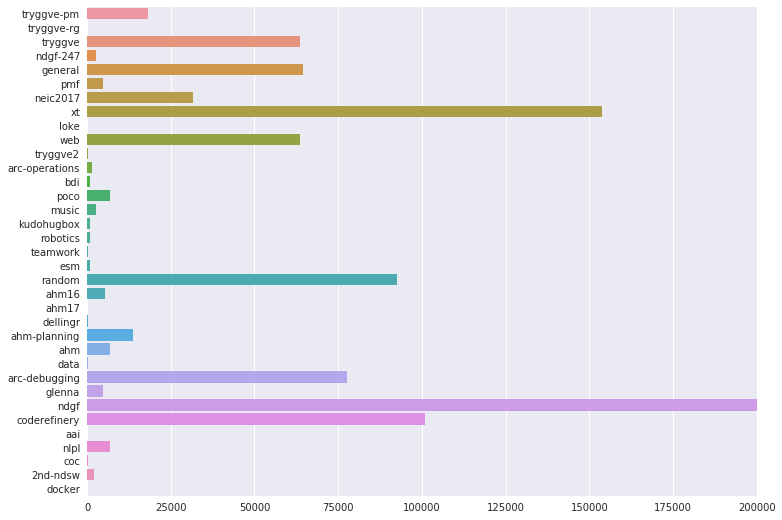

In [165]:
plt.rcParams["figure.figsize"] = [12,9]
x = words_in_channels.keys()
y = [len(words_in_channels[i]) for i in words_in_channels.keys()]
ax = sns.barplot(x=y, y=x)

ax.set_xlim([0,200000])

From now on, let's focus on the largest channels

In [167]:
channels = ["tryggve","general","xt","web","random","arc-debugging","ndgf","coderefinery"]

### Simple natural language processing

Natural language toolkit tests

In [126]:
import nltk as nltk

 > Note: lots of extra packages need to be downloaded with `nltk.download()`

Frequency distribution of words

In [127]:
#sorted(set(words))
most_common_words = dict.fromkeys(channels,0)
dists = dict.fromkeys(channels,0)
for channel in channels:
    words = words_in_channels[channel]
    dist = nltk.FreqDist(words)
    dists[channel] = dist
    most_common_words[channel] = dist.most_common(20)


In [128]:
type(dist)

nltk.probability.FreqDist

In [129]:
type(most_common_words["coderefinery"][0])

tuple

We create a dataframe to work with:

In [131]:
df_words = pd.DataFrame(data=most_common)
df_words.head(30)

,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
0,"(., 7377)","(., 6682)","(., 4981)","(., 137892)","(., 7545)","(., 5807)","(., 5131)","(., 12970)"
1,"(the, 2819)","(the, 3451)","(,, 2123)","(the, 44224)","(the, 3120)","(the, 1993)","(the, 2276)","(,, 5274)"
2,"(,, 2441)","(to, 2927)","(the, 2035)","(,, 42199)","(,, 2917)","(,, 1765)","(,, 2163)","(the, 5209)"
3,"(to, 1521)","(,, 2738)","(to, 1638)","(to, 28195)","(to, 2064)","(to, 1608)","(to, 1741)","(to, 3767)"
4,"(is, 1346)","(i, 2553)","(i, 1255)","(i, 20131)","(a, 1854)","(i, 1297)","(i, 1297)","(i, 2887)"
5,"(i, 1258)","(and, 1719)","(a, 1015)","(it, 19853)","(i, 1621)","(?, 977)","(a, 1030)","(?, 2423)"
6,"(it, 1133)","(a, 1685)","(and, 968)","(?, 18728)","(of, 1286)","(you, 897)","(it, 944)","(a, 2162)"
7,"(a, 1043)","(we, 1497)","(is, 864)","(is, 18423)","(and, 1272)","(a, 824)","(is, 825)","(in, 2090)"
8,"(?, 1034)","(it, 1450)","(it, 857)","(a, 16716)","(in, 1208)","(in, 798)","(?, 824)","(and, 2075)"
9,"(in, 944)","(is, 1440)","(in, 810)","(and, 14484)","(is, 1175)","(is, 763)","(that, 785)","(for, 1994)"


In [132]:
common_words = []
for index, row in df.iterrows():
    for r in row:
        common_words.append(r[0])
common_words = set(common_words)
common_words

{u'!',
 u',',
 u'-',
 u'.',
 u'?',
 u'a',
 u'and',
 u'be',
 u'but',
 u'for',
 u'have',
 u'i',
 u'in',
 u'is',
 u'it',
 u'my',
 u'not',
 u'of',
 u'on',
 u'so',
 u'that',
 u'the',
 u'this',
 u'to',
 u'we',
 u'you'}

> *Exercise: create a new dataframe with the common words as indices and number of appearances as values alon rows*

Let's look at lexical diversity, i.e. ratio of number of distinct words and total number of words

In [133]:
def lexical_diversity(text):
    return len(set(text)) / len(text)

In [134]:
for channel in channels: # loop over the largest channels
    words = words_in_channels[channel]
    lex_div = lexical_diversity(words)
    print("Lexical diversity in %s is %f"%(channel,lex_div))
#len(set(words))/len(words)

Lexical diversity in tryggve is 0.112514
Lexical diversity in general is 0.130332
Lexical diversity in xt is 0.087830
Lexical diversity in web is 0.111274
Lexical diversity in random is 0.141009
Lexical diversity in arc-debugging is 0.102376
Lexical diversity in ndgf is 0.042872
Lexical diversity in coderefinery is 0.089686


## "Sentiment analysis": emojis

Emojis in the Slack logs are expressed like `:slightly_smiling_face:` 

In [135]:
most_common_emojis = dict.fromkeys(channels,0)
dists_emojis = dict.fromkeys(channels,0)

for channel in channels:
    words = words_in_channels[channel]
    # need to join words for the FreqDist method
    all_words = " ".join(words)

    #emojis = re.findall(r":\w*:",all_words) # this includes strings like :43:
    emojis = re.findall(r":[a-zA-Z_]+:",all_words) # this filters out strings like :43:
 
    dist = nltk.FreqDist(emojis)
    dist.most_common(20)
    
    dists_emojis[channel] = dist
    most_common_emojis[channel] = dist.most_common(40)
    
most_common_emojis


{'arc-debugging': [(u':slightly_smiling_face:', 112),
  (u':simple_smile:', 25),
  (u':wink:', 11),
  (u':disappointed:', 11),
  (u':container_helpers:', 8),
  (u':scheduler:', 6),
  (u':sunglasses:', 6),
  (u':threadargument:', 5),
  (u':pluginsfactory:', 4),
  (u':dtr:', 3),
  (u':processor:', 3),
  (u':filecache:', 3),
  (u':threads:', 3),
  (u':e:', 2),
  (u':mutex:', 2),
  (u':fileaccess:', 2),
  (u':run:', 2),
  (u':datapointindex:', 2),
  (u':datapointloader:', 1),
  (u':smiling_imp:', 1),
  (u':evil_smile:', 1),
  (u':recmutex:', 1),
  (u':datastatus:', 1),
  (u':confused:', 1),
  (u':thinking_face:', 1),
  (u':scream:', 1),
  (u':payloadtcpsocket:', 1),
  (u':inputfile:', 1),
  (u':grimacing:', 1)],
 'coderefinery': [(u':slightly_smiling_face:', 197),
  (u':wink:', 14),
  (u':stuck_out_tongue:', 6),
  (u':smile:', 6),
  (u':disappointed:', 4),
  (u':converters:', 3),
  (u':grinning:', 3),
  (u':simple_smile:', 2),
  (u':eyes:', 1),
  (u':laughing:', 1),
  (u':flushed:', 1),
  

Let's find the unique emojis

In [136]:
unique_emojis = set()
for i in most_common_emojis.keys():
    for j in most_common_emojis[i]:
        unique_emojis.add(j[0])
unique_emojis

{u':a:',
 u':ad:',
 u':alarm_clock:',
 u':astonished:',
 u':baby:',
 u':baca:',
 u':basketball:',
 u':bb:',
 u':bbff:',
 u':bear:',
 u':beef:',
 u':beer:',
 u':beers:',
 u':behrmann:',
 u':bike:',
 u':birthday:',
 u':black:',
 u':blush:',
 u':bouquet:',
 u':bow:',
 u':bringonline:',
 u':bulb:',
 u':cafe:',
 u':cake:',
 u':calling:',
 u':canofworms:',
 u':cc:',
 u':champagne:',
 u':clap:',
 u':cloud:',
 u':coffee:',
 u':coffin:',
 u':cold_sweat:',
 u':computer:',
 u':confused:',
 u':container_helpers:',
 u':converters:',
 u':cry:',
 u':d:',
 u':dancer:',
 u':datapointindex:',
 u':datapointloader:',
 u':datastatus:',
 u':dc:',
 u':ddff:',
 u':disappointed:',
 u':dollar:',
 u':drumroll:',
 u':dtr:',
 u':e:',
 u':earth_americas:',
 u':ef:',
 u':error:',
 u':evergreen_tree:',
 u':evil_smile:',
 u':eyes:',
 u':face_with_head_bandage:',
 u':face_with_rolling_eyes:',
 u':fb:',
 u':feba:',
 u':ff:',
 u':ffff:',
 u':fileaccess:',
 u':filecache:',
 u':fire:',
 u':flashlight:',
 u':flushed:',
 u':

Let's investigate a few key emojis, in increasing order of positivity

In [137]:
import emoji
key_emojis = [u":disappointed:",u":confused:",u":flushed:",u":wink:",u":slightly_smiling_face:",
              u":thumbsup:",u":clap:",u":stuck_out_tongue:",u":smile:",  
               u":grinning:",u":heart_eyes:",u":laughing:"]
#print "hello"
for i in key_emojis:
    print i
    print(emoji.emojize('NeIC is %s'%i, use_aliases=True))


:disappointed:
NeIC is 😞
:confused:
NeIC is 😕
:flushed:
NeIC is 😳
:wink:
NeIC is 😉
:slightly_smiling_face:
NeIC is 🙂
:thumbsup:
NeIC is 👍
:clap:
NeIC is 👏
:stuck_out_tongue:
NeIC is 😛
:smile:
NeIC is 😄
:grinning:
NeIC is 😀
:heart_eyes:
NeIC is 😍
:laughing:
NeIC is 😆


In [138]:
tmp = most_common_emojis.copy()
for i in most_common_emojis:
#for i in tmp:
    excluded_emojis = [x[0] for x in most_common_emojis[i] if x[0] in key_emojis]
#    excluded_emojis = [x[0] for x in tmp[i] if x[0] in key_emojis]
    l1 = [x for x in most_common_emojis[i] if x[0] in key_emojis]
    l2 = [(x,0) for x in key_emojis if x not in excluded_emojis]
    print l1
    print l2
    newlist = l1 + l2
    newlist.sort()
    most_common_emojis[i] = newlist
    #tmp[i] = newlist.sort()
most_common_emojis

[(u':slightly_smiling_face:', 118), (u':smile:', 33), (u':wink:', 31), (u':clap:', 28), (u':disappointed:', 17), (u':grinning:', 10), (u':stuck_out_tongue:', 6), (u':confused:', 5), (u':thumbsup:', 2)]
[(u':flushed:', 0), (u':heart_eyes:', 0), (u':laughing:', 0)]
[(u':slightly_smiling_face:', 197), (u':wink:', 14), (u':stuck_out_tongue:', 6), (u':smile:', 6), (u':disappointed:', 4), (u':grinning:', 3), (u':laughing:', 1), (u':flushed:', 1), (u':thumbsup:', 1)]
[(u':confused:', 0), (u':clap:', 0), (u':heart_eyes:', 0)]
[(u':slightly_smiling_face:', 528), (u':disappointed:', 122), (u':wink:', 60), (u':smile:', 38), (u':confused:', 11), (u':stuck_out_tongue:', 10)]
[(u':flushed:', 0), (u':thumbsup:', 0), (u':clap:', 0), (u':grinning:', 0), (u':heart_eyes:', 0), (u':laughing:', 0)]
[(u':slightly_smiling_face:', 103), (u':smile:', 22), (u':wink:', 7), (u':stuck_out_tongue:', 6), (u':disappointed:', 4), (u':clap:', 2)]
[(u':confused:', 0), (u':flushed:', 0), (u':thumbsup:', 0), (u':grinning:

{'arc-debugging': [(u':clap:', 0),
  (u':confused:', 1),
  (u':disappointed:', 11),
  (u':flushed:', 0),
  (u':grinning:', 0),
  (u':heart_eyes:', 0),
  (u':laughing:', 0),
  (u':slightly_smiling_face:', 112),
  (u':smile:', 0),
  (u':stuck_out_tongue:', 0),
  (u':thumbsup:', 0),
  (u':wink:', 11)],
 'coderefinery': [(u':clap:', 0),
  (u':confused:', 0),
  (u':disappointed:', 4),
  (u':flushed:', 1),
  (u':grinning:', 3),
  (u':heart_eyes:', 0),
  (u':laughing:', 1),
  (u':slightly_smiling_face:', 197),
  (u':smile:', 6),
  (u':stuck_out_tongue:', 6),
  (u':thumbsup:', 1),
  (u':wink:', 14)],
 'general': [(u':clap:', 7),
  (u':confused:', 1),
  (u':disappointed:', 4),
  (u':flushed:', 0),
  (u':grinning:', 4),
  (u':heart_eyes:', 0),
  (u':laughing:', 0),
  (u':slightly_smiling_face:', 120),
  (u':smile:', 17),
  (u':stuck_out_tongue:', 2),
  (u':thumbsup:', 4),
  (u':wink:', 40)],
 'ndgf': [(u':clap:', 0),
  (u':confused:', 11),
  (u':disappointed:', 122),
  (u':flushed:', 0),
  (u':g

In [139]:
df_emojis = pd.DataFrame(data=most_common_emojis)
df_emojis.head(5)

,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
0,"(:clap:, 0)","(:clap:, 0)","(:clap:, 7)","(:clap:, 0)","(:clap:, 6)","(:clap:, 28)","(:clap:, 2)","(:clap:, 22)"
1,"(:confused:, 1)","(:confused:, 0)","(:confused:, 1)","(:confused:, 11)","(:confused:, 2)","(:confused:, 5)","(:confused:, 0)","(:confused:, 2)"
2,"(:disappointed:, 11)","(:disappointed:, 4)","(:disappointed:, 4)","(:disappointed:, 122)","(:disappointed:, 18)","(:disappointed:, 17)","(:disappointed:, 4)","(:disappointed:, 18)"
3,"(:flushed:, 0)","(:flushed:, 1)","(:flushed:, 0)","(:flushed:, 0)","(:flushed:, 0)","(:flushed:, 0)","(:flushed:, 0)","(:flushed:, 0)"
4,"(:grinning:, 0)","(:grinning:, 3)","(:grinning:, 4)","(:grinning:, 0)","(:grinning:, 3)","(:grinning:, 10)","(:grinning:, 0)","(:grinning:, 11)"


Extract the emojis from one of the columns, and set it to the row indices 

In [140]:
emojis, y = zip(*df_emojis.coderefinery)
df_emojis['emojis'] = emojis
df_emojis.set_index('emojis',drop=True, inplace=True)
df_emojis.head(5)

,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
emojis,,,,,,,,
:clap:,"(:clap:, 0)","(:clap:, 0)","(:clap:, 7)","(:clap:, 0)","(:clap:, 6)","(:clap:, 28)","(:clap:, 2)","(:clap:, 22)"
:confused:,"(:confused:, 1)","(:confused:, 0)","(:confused:, 1)","(:confused:, 11)","(:confused:, 2)","(:confused:, 5)","(:confused:, 0)","(:confused:, 2)"
:disappointed:,"(:disappointed:, 11)","(:disappointed:, 4)","(:disappointed:, 4)","(:disappointed:, 122)","(:disappointed:, 18)","(:disappointed:, 17)","(:disappointed:, 4)","(:disappointed:, 18)"
:flushed:,"(:flushed:, 0)","(:flushed:, 1)","(:flushed:, 0)","(:flushed:, 0)","(:flushed:, 0)","(:flushed:, 0)","(:flushed:, 0)","(:flushed:, 0)"
:grinning:,"(:grinning:, 0)","(:grinning:, 3)","(:grinning:, 4)","(:grinning:, 0)","(:grinning:, 3)","(:grinning:, 10)","(:grinning:, 0)","(:grinning:, 11)"


We can do better, let's create real emojis

In [141]:
emojis2=[]
for i in emojis:
    x = emoji.emojize(i, use_aliases=True) 
    emojis2.append(x)
df_emojis["emojis"] = emojis2
df_emojis.set_index('emojis',inplace=True)
df_emojis.head(5)

,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
emojis,,,,,,,,
👏,"(:clap:, 0)","(:clap:, 0)","(:clap:, 7)","(:clap:, 0)","(:clap:, 6)","(:clap:, 28)","(:clap:, 2)","(:clap:, 22)"
😕,"(:confused:, 1)","(:confused:, 0)","(:confused:, 1)","(:confused:, 11)","(:confused:, 2)","(:confused:, 5)","(:confused:, 0)","(:confused:, 2)"
😞,"(:disappointed:, 11)","(:disappointed:, 4)","(:disappointed:, 4)","(:disappointed:, 122)","(:disappointed:, 18)","(:disappointed:, 17)","(:disappointed:, 4)","(:disappointed:, 18)"
😳,"(:flushed:, 0)","(:flushed:, 1)","(:flushed:, 0)","(:flushed:, 0)","(:flushed:, 0)","(:flushed:, 0)","(:flushed:, 0)","(:flushed:, 0)"
😀,"(:grinning:, 0)","(:grinning:, 3)","(:grinning:, 4)","(:grinning:, 0)","(:grinning:, 3)","(:grinning:, 10)","(:grinning:, 0)","(:grinning:, 11)"


Extract only the numbers from the dataframe tuples

In [142]:
for x in df_emojis:
    dummy, y = zip(*df_emojis[x])
    df_emojis[x] = y
df_emojis.head(5)

,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
emojis,,,,,,,,
👏,0,0,7,0,6,28,2,22
😕,1,0,1,11,2,5,0,2
😞,11,4,4,122,18,17,4,18
😳,0,1,0,0,0,0,0,0
😀,0,3,4,0,3,10,0,11


Normalize to total number of selected emojis in each channel

In [143]:
df_tmp = 100*df_emojis/df_emojis.sum()
df_tmp.round(1)

,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
emojis,,,,,,,,
👏,0.0,0.0,3.5,0.0,2.1,11.2,1.4,7.1
😕,0.7,0.0,0.5,1.4,0.7,2.0,0.0,0.6
😞,8.1,1.7,2.0,15.9,6.2,6.8,2.8,5.8
😳,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
😀,0.0,1.3,2.0,0.0,1.0,4.0,0.0,3.5
😍,0.0,0.0,0.0,0.0,2.8,0.0,0.0,0.0
😆,0.0,0.4,0.0,0.0,2.4,0.0,0.0,0.6
🙂,83.0,84.5,60.3,68.7,50.0,47.2,71.5,33.0
😄,0.0,2.6,8.5,4.9,12.8,13.2,15.3,14.1


### Conclusions

(virtually speaking...)
- NeIC people smile a lot overall 
- There's not a lot of clapping and thumbs-up-giving, except for `XT` people who gesticulate quite a lot with their hands
- On the other hand, `XT`-ers don't slightly as much as other channels, but they laugh quite a bit
- The most ambiguous communication takes place on `random` and `general`, as evidenced by the high proportion of winking
- `NDGF`-ers are the most disappointed channel. Anything we can do to help guys? 😉 

In [144]:
# don't really need a heatmap plot

#emojis currently don't work as y-labels
#%matplotlib inline
##normalize:
#plt.rcParams["figure.figsize"] = [12.0, 8.0]
#plt.rcParams['figure.dpi'] = 300
#sns.set(font='Segoe UI Emoji')
#norm = 100*df_emojis / df_emojis.sum()

#g = sns.heatmap(norm,linewidths=.5,annot=True,cbar=True)
#plt.show()

**Collocations and bigrams**

In [145]:
from nltk.book import *

In [146]:
#nltk.download('treebank')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/ktw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ktw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [147]:
tokens = nltk.word_tokenize(all_words)
text = nltk.Text(tokens)

In [148]:
text.collocations()

would like; next week; good morning; feel free; good idea; steering
group; n't know; installation instructions; pull request; makes sense;
mailing list; make sure; git intro; n't want; business cards; somebody
else; install instructions; google drive; one thing; good point


**Searching for words**

In [149]:
text.concordance("fantastic")

Displaying 5 of 5 matches:
ay5a > < @ u2k0egsc8 > thank you ! fantastic work . i think we made a splash . 
 we refine on monday that would be fantastic . i am ready to send a postcard fr
pandas ( but the pandas session is fantastic so do not delete anything ) but fo
 session , that would of course be fantastic , the session is well converged an
 the channel ) - i think this is a fantastic solution to publish both the graph


Words that appear in similar contexts:

In [150]:
text.similar("is")

s was in and on but to are for with does that out if i did so we as at


Generate random text in the same style as other text

In [151]:
text.generate?

### LDA 

First need some preprocessing

In [169]:
# we'll join all words for each channel
joined_words_in_channels = dict.fromkeys(channels)
for i in channels:
    words = words_in_channels[i]
    joined_words_in_channels[i] = " ".join(words)


In [174]:
import textmining

tdm = textmining.TermDocumentMatrix()
for channel in channels:
    tdm.add_doc(joined_words_in_channels[channel])

# write term document matrix to csv file
tdm.write_csv('matrix2.csv', cutoff=1)


In [206]:
#for row in tdm.rows(cutoff=1):
#    print type(row)
vocab = list(tdm.rows(cutoff=1))[0]
titles = channels
X = np.array(list(tdm.rows(cutoff=1))[1:])

X.shape

(8, 34221)

In [207]:
model = lda.LDA(n_topics=20, n_iter=1500, random_state=1)
model.fit(X)  # model.fit_transform(X) is also available
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

INFO:lda:n_documents: 8
INFO:lda:vocab_size: 34221
INFO:lda:n_words: 1719876
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -17681492
INFO:lda:<10> log likelihood: -15958305
INFO:lda:<20> log likelihood: -15206553
INFO:lda:<30> log likelihood: -14895994
INFO:lda:<40> log likelihood: -14693286
INFO:lda:<50> log likelihood: -14531915
INFO:lda:<60> log likelihood: -14394046
INFO:lda:<70> log likelihood: -14285999
INFO:lda:<80> log likelihood: -14179600
INFO:lda:<90> log likelihood: -14077542
INFO:lda:<100> log likelihood: -13976156
INFO:lda:<110> log likelihood: -13899171
INFO:lda:<120> log likelihood: -13819313
INFO:lda:<130> log likelihood: -13734086
INFO:lda:<140> log likelihood: -13661188
INFO:lda:<150> log likelihood: -13588003
INFO:lda:<160> log likelihood: -13531060
INFO:lda:<170> log likelihood: -13477129
INFO:lda:<180> log likelihood: -13417687
INFO:lda:<190> log likelihood: -13356809
INFO:lda:<200> log likelihood: -13311686
INFO:lda:<210> log likelihood

Topic 0: the it to i is a that but
Topic 1: of a they s and was in time
Topic 2: ll nagios run srm pools alice host test
Topic 3: tryggve u q s you hangout e com
Topic 4: lot getting didn last being off already actually
Topic 5: we u to can this https would do
Topic 6: ku piggy java update petter meeting ood reboot
Topic 7: neic of all your ahm has joel interesting
Topic 8: and we will coderefinery i workshop people good
Topic 9: billing guess had door bunsen sec okay lunch
Topic 10: gt info these wait state first bug perhaps
Topic 11: dcache we ndgf tiggi org dmytrok atlas pool
Topic 12: arc jobs this a atlas in files c
Topic 13: home flight any were year them f sweden
Topic 14: it t don at good something see before
Topic 15: neic no wiki nordforsk github org people f
Topic 16: u meeting you m at google w wap
Topic 17: my at one m people com face d
Topic 18: xt in the gudmund neic jr for i
Topic 19: the i to a is and in that


From the fit model we can look at the topic-word probabilities

In [209]:
topic_word = model.topic_word_

for n in range(5):
    sum_pr = sum(topic_word[n,:])
    print("topic: {} sum: {}".format(n, sum_pr))

topic: 0 sum: 1.0
topic: 1 sum: 1.0
topic: 2 sum: 1.0
topic: 3 sum: 0.999999999999
topic: 4 sum: 1.0


In [211]:
n = 15
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]
    print('*Topic {}\n- {}'.format(i, ' '.join(topic_words)))

*Topic 0
- the it to i is a that but and s t can on of for
*Topic 1
- of a they s and was in time the you com but u www too
*Topic 2
- ll nagios run srm pools alice host test upgrade wiki clom jobs chrulle yeah maybe
*Topic 3
- tryggve u q s you hangout e com channel https amef kudos tsd d any
*Topic 4
- lot getting didn last being off already actually user big system every far real case
*Topic 5
- we u to can this https would do it one but i thanks ok need
*Topic 6
- ku piggy java update petter meeting ood reboot logstash neic bccs next haproxy net slurm
*Topic 7
- neic of all your ahm has joel interesting channel slack wiki who nordic nordforsk j
*Topic 8
- and we will coderefinery i workshop people good git kv fvnv com meeting our github
*Topic 9
- billing guess had door bunsen sec okay lunch load dn page raid ping git lost
*Topic 10
- gt info these wait state first bug perhaps again if very each updated upload itself
*Topic 11
- dcache we ndgf tiggi org dmytrok atlas pool hpc maswa

The other information we get from the model is document-topic probabilities

In [216]:
doc_topic = model.doc_topic_
for n in range(8):
    topic_most_pr = doc_topic[n].argmax()
    print("doc: {} topic: {}\n{}...".format(n,topic_most_pr,titles[n][:50]))

doc: 0 topic: 19
tryggve...
doc: 1 topic: 19
general...
doc: 2 topic: 19
xt...
doc: 3 topic: 19
web...
doc: 4 topic: 19
random...
doc: 5 topic: 0
arc-debugging...
doc: 6 topic: 0
ndgf...
doc: 7 topic: 19
coderefinery...


In [222]:
doc_topic

(8, 20)

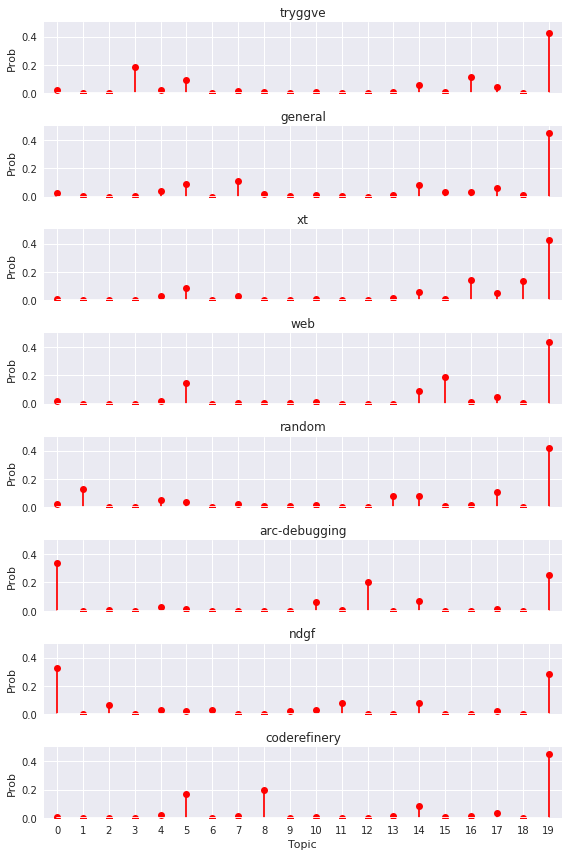

In [235]:
f, ax= plt.subplots(8, 1, figsize=(8, 12), sharex=True)
#for i, k in enumerate([0, 1, 2, 3, 4, 5, 6, 7]):
for i, k in enumerate([0, 1, 2, 3,4,5,6,7]):
    ax[i].stem(doc_topic[k,:], linefmt='r-',
               markerfmt='ro', basefmt='w-')
    ax[i].set_xlim(-0.5, 19.5)
    ax[i].set_xticks(range(20))
    ax[i].set_ylim(0, .5)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("{}".format(channels[k]))

ax[7].set_xlabel("Topic")

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

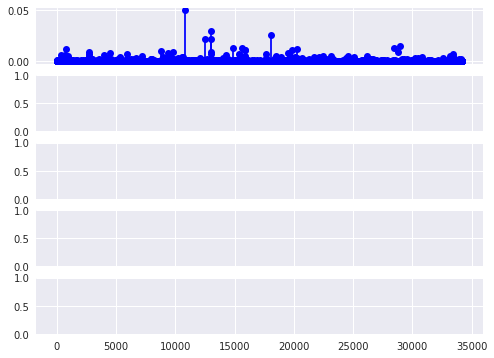

In [217]:
f, ax= plt.subplots(5, 1, figsize=(8, 6), sharex=True)
for i, k in enumerate([0, 5, 9, 14, 19]):
    ax[i].stem(topic_word[k,:], linefmt='b-',
               markerfmt='bo', basefmt='w-')
    ax[i].set_xlim(-50,4350)
    ax[i].set_ylim(0, 0.08)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("topic {}".format(k))

ax[4].set_xlabel("word")

plt.tight_layout()
plt.show()

### Test case

In [152]:
import lda
import lda.datasets
X = lda.datasets.load_reuters()
lda.datasets.load_reuters_vocab?
vocab = lda.datasets.load_reuters_vocab()
titles = lda.datasets.load_reuters_titles()
print(X.shape)
print(X.sum())
model = lda.LDA(n_topics=20, n_iter=1500, random_state=1)
#model.fit(X)  # model.fit_transform(X) is also available
#for i in X:
#    print i

(395, 4258)
84010


In [153]:
titles

('0 UK: Prince Charles spearheads British royal revolution. LONDON 1996-08-20',
 '1 GERMANY: Historic Dresden church rising from WW2 ashes. DRESDEN, Germany 1996-08-21',
 "2 INDIA: Mother Teresa's condition said still unstable. CALCUTTA 1996-08-23",
 '3 UK: Palace warns British weekly over Charles pictures. LONDON 1996-08-25',
 '4 INDIA: Mother Teresa, slightly stronger, blesses nuns. CALCUTTA 1996-08-25',
 "5 INDIA: Mother Teresa's condition unchanged, thousands pray. CALCUTTA 1996-08-25",
 '6 INDIA: Mother Teresa shows signs of strength, blesses nuns. CALCUTTA 1996-08-26',
 "7 INDIA: Mother Teresa's condition improves, many pray. CALCUTTA, India 1996-08-25",
 '8 INDIA: Mother Teresa improves, nuns pray for "miracle". CALCUTTA 1996-08-26',
 '9 UK: Charles under fire over prospect of Queen Camilla. LONDON 1996-08-26',
 '10 UK: Britain tells Charles to forget Camilla. LONDON 1996-08-27',
 "11 COTE D'IVOIRE: FEATURE - Quiet homecoming for reprieved Ivory Coast maid. ABIDJAN 1996-08-28",


In [154]:
import lda
import lda.datasets
X = lda.datasets.load_reuters()
vocab = lda.datasets.load_reuters_vocab()
titles = lda.datasets.load_reuters_titles()
X.shape
X.sum()
model = lda.LDA(n_topics=20, n_iter=1500, random_state=1)
model.fit(X)  # model.fit_transform(X) is also available
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

INFO:lda:n_documents: 395
INFO:lda:vocab_size: 4258
INFO:lda:n_words: 84010
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -1051748
INFO:lda:<10> log likelihood: -719800
INFO:lda:<20> log likelihood: -699115
INFO:lda:<30> log likelihood: -689370
INFO:lda:<40> log likelihood: -684918
INFO:lda:<50> log likelihood: -681322
INFO:lda:<60> log likelihood: -678979
INFO:lda:<70> log likelihood: -676598
INFO:lda:<80> log likelihood: -675383
INFO:lda:<90> log likelihood: -673316
INFO:lda:<100> log likelihood: -672761
INFO:lda:<110> log likelihood: -671320
INFO:lda:<120> log likelihood: -669744
INFO:lda:<130> log likelihood: -669292
INFO:lda:<140> log likelihood: -667940
INFO:lda:<150> log likelihood: -668038
INFO:lda:<160> log likelihood: -667429
INFO:lda:<170> log likelihood: -666475
INFO:lda:<180> log likelihood: -665562
INFO:lda:<190> log likelihood: -664920
INFO:lda:<200> log likelihood: -664979
INFO:lda:<210> log likelihood: -664722
INFO:lda:<220> log likelihood: -

Topic 0: british churchill sale million major letters west britain
Topic 1: church government political country state people party against
Topic 2: elvis king fans presley life concert young death
Topic 3: yeltsin russian russia president kremlin moscow michael operation
Topic 4: pope vatican paul john surgery hospital pontiff rome
Topic 5: family funeral police miami versace cunanan city service
Topic 6: simpson former years court president wife south church
Topic 7: order mother successor election nuns church nirmala head
Topic 8: charles prince diana royal king queen parker bowles
Topic 9: film french france against bardot paris poster animal
Topic 10: germany german war nazi letter christian book jews
Topic 11: east peace prize award timor quebec belo leader
Topic 12: n't life show told very love television father
Topic 13: years year time last church world people say
Topic 14: mother teresa heart calcutta charity nun hospital missionaries
Topic 15: city salonika capital buddhist c

In [155]:
print(vocab)

('church', 'pope', 'years', 'people', 'mother', 'last', 'told', 'first', 'world', 'year', 'president', 'teresa', 'charles', 'catholic', 'during', 'life', 'u.s', 'city', 'public', 'time', 'since', 'family', 'king', 'former', 'british', 'harriman', 'against', 'country', 'vatican', 'made', 'three', 'hospital', 'minister', 'home', 'died', 'tuesday', 'government', "n't", 'million', 'prince', 'john', 'very', 'war', 'say', 'order', 'day', 'political', 'leader', 'heart', 'roman', 'yeltsin', 'later', 'france', 'party', 'monday', 'death', 'clinton', 'sunday', 'elvis', 'state', 'diana', 'royal', 'wednesday', 'churchill', 'official', 'service', 'including', 'film', 'while', 'week', 'left', 'work', 'paris', 'around', 'american', 'saying', 'take', 'doctors', 'group', 'son', 'queen', 'house', 'police', 'national', 'under', 'surgery', 'next', 'peace', 'paul', 'long', 'ceremony', 'month', 'thursday', 'french', 'head', 'marriage', 'operation', 'visit', 'show', 'germany', 'russian', 'days', 'love', 'news